In [28]:
import os, warnings, sys, yaml
from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv
# warnings.simplefilter('always')
_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dbpath_old = jnconfig['dbpath_old']
dbpath_new = jnconfig['dbpath_new']

In [87]:
from obspy import read, UTCDateTime
from obspy.io.xseed import Parser
from obspy.signal import PPSD
from obspy.signal.spectral_estimation import get_nlnm
import math

def psd(segment):
    tr = segment.stream()[0]
    dt = (segment.arrival_time - tr.stats.starttime.datetime).total_seconds()
    tr = tr.slice(tr.stats.starttime, UTCDateTime(segment.arrival_time))
    ppsd = PPSD(tr.stats, metadata=segment.inventory(), ppsd_length=int(dt))
    ppsd.add(tr)
    return ppsd


def psd_values(segment, periods):
    periods = np.asarray(periods)
    ppsd_ = psd(segment)
    val = np.interp(np.log10(periods), np.log10(ppsd_.period_bin_centers), ppsd_.psd_values[0])
    val[periods < ppsd_.period_bin_centers[0]] = np.nan
    val[periods > ppsd_.period_bin_centers[-1]] = np.nan
    return val

nlnm_x, nlnm_y = get_nlnm()
nlnm_x, nlnm_y = nlnm_x[::-1], nlnm_y[::-1]

def nlnm_values():
    periods = [0.1, 1, 10, 20, 50, 100]
    for p in periods:
        for i, x in enumerate(nlnm_x):
            if p == x:
                print(x, nlnm_y[i])
                break
            elif (x > p):
                idx = i if abs(p - x) < abs(p - nlnm_x[i+1]) else i+1
                print(x, nlnm_y[idx])
                break

nlnm_values()

0.1 -168.0
1.00462 -166.342
10.09253 -163.876
20.1372 -173.696
50.1187 -187.5
100.0 -185.07


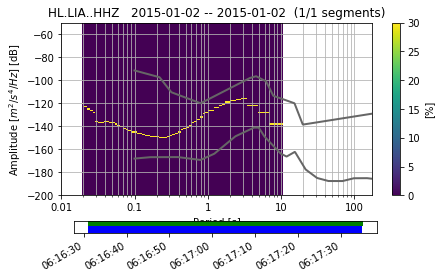

[0.1, 1, 10, 20, 50, 100]
[-144.44221161 -127.51720061 -137.15687561           nan           nan
           nan]


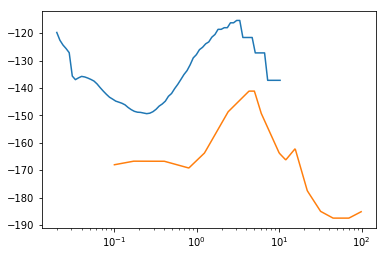

In [88]:
from obspy import Trace, Stream, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

sess = get_session(dbpath_new)
try:
    qry = sess.query(Segment).join(Segment.station).filter(Station.has_inventory &
                                                           Segment.has_data &
                                                           Segment.maxgap_numsamples.between(-0.5,0.5))
    segment = qry.limit(1).first()
    
    _ = psd(segment)
    _.plot()

    # print(_.period_bin_centers.shape, _.psd_values[0].shape)
    plt.semilogx(_.period_bin_centers, _.psd_values[0])
    trace, inv = segment.stream()[0], segment.inventory()
    
    periods = [0.1, 1, 10, 20, 50, 100]
    print(periods)
    print(psd_values(segment, periods))
    
finally:
    sess.close()

p, s = get_nlnm()
# print(p[::-1][:500])
plt.semilogx(p[::-1][:500], s[::-1][:500])
    
def printred(string):
    print("\x1b[31m%s\x1b[0m" % string)

In [ ]:
# all values above 1 period are considered "low freqs". Also consider that values close to 10 have more variability,
# because the source (the physic process) is variable

In [ ]:
periods = [0.1, 1, 10, 20, 50, 100]
print(psd_values(segment, periods))